### A simple lensing reconstruction in flat sky

In [1]:
import numpy as np
import tqdm
from cmblensplus import basic, flatsky
import cmb
import binning
from matplotlib.pyplot import *

In [2]:
# parameters
Tcmb = 2.72e6
lmax = 3000
rL = [100,2500]
oL = [2,3000]
nx, ny = 512, 512
D  = np.array([nx,ny]) / 60.*np.pi/180.
bn = 50
mc = 10
qlist = ['TT','TE','TB','EE','EB']

In [3]:
# binned multipoles
bp, bc = binning.binned_ells(bn,oL[0],oL[1])

In [4]:
# multipoles on grids
lx, ly, el, il = flatsky.utils.elarrays(nx,ny,D)
kl = el*(el+1.)/2.

In [5]:
# load unlensed and lensed Cls
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
itt     = np.zeros(lmax+1)
iee     = np.zeros(lmax+1)
ibb     = np.zeros(lmax+1)
itt[2:] = 1./lcl[0,2:]
iee[2:] = 1./lcl[1,2:]
ibb[2:] = 1./lcl[2,2:]

In [6]:
# assign 1d cl on 2d grid
cltt = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,lcl[0,:])
clee = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,lcl[1,:])
clte = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,lcl[3,:])
iltt = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,itt)
ilee = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,iee)
ilbb = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,ibb)

In [7]:
# compute analytic normalization with 2d filtering
Ag, Ac = {}, {}
Ag['TT'], Ac['TT'] = flatsky.norm_lens.qtt(nx,ny,D,rL,iltt,cltt,oL)

In [8]:
Ag['TE'], Ac['TE'] = flatsky.norm_lens.qte(nx,ny,D,rL,iltt,ilee,clte,oL)
Ag['TB'], Ac['TB'] = flatsky.norm_lens.qtb(nx,ny,D,iltt,ilbb,clte,rL,oL)
Ag['EE'], Ac['EE'] = flatsky.norm_lens.qee(nx,ny,D,ilee,clee,rL,oL)
Ag['EB'], Ac['EB'] = flatsky.norm_lens.qeb(nx,ny,D,ilee,ilbb,clee,rL,oL)

In [9]:
# kappa binned spectrum
Alg = {q: flatsky.utils.c2d2bcl(nx,ny,D,kl**2*Ag[q],bn,oL) for q in qlist}
Alc = {q: flatsky.utils.c2d2bcl(nx,ny,D,kl**2*Ac[q],bn,oL) for q in qlist}

In [10]:
TT2d = flatsky.utils.cl2c2d(nx,ny,D,2,lmax,lcl[0])

In [11]:
np.sum(TT2d)

3.049465796962216e-11

In [12]:
# save
#np.savetxt('al_grad.dat',np.array((bc,Alg['TT'],Alg['TE'],Alg['TB'],Alg['EE'],Alg['EB'])).T,fmt='%8.6e')
#np.savetxt('al_curl.dat',np.array((bc,Alc['TT'],Alc['TE'],Alc['TB'],Alc['EE'],Alc['EB'])).T,fmt='%8.6e')

In [13]:
# loop over MC realizations
cks = {q: np.zeros((mc,bn)) for q in qlist}

for i in tqdm.tqdm(range(mc)):
    
    # generate Fourier mode on 2d grids
    tlm, elm = flatsky.utils.gauss2alm(nx,ny,D,2,lmax,lcl[0,:],lcl[3,:],lcl[1,:])
    blm = flatsky.utils.gauss1alm(nx,ny,D,2,lmax,lcl[2,:])

    #cls[i,0,:] = flatsky.utils.alm2bcl(bn,oL,nx,ny,D,tlm)
    #cls[i,1,:] = flatsky.utils.alm2bcl(bn,oL,nx,ny,D,tlm,elm)
    #cls[i,2,:] = flatsky.utils.alm2bcl(bn,oL,nx,ny,D,elm)

    # filtering
    tlm *= iltt
    elm *= ilee
    blm *= ilbb

    # reconstruction
    klm = {}
    klm['TT'], clm = flatsky.rec_lens.qtt(nx,ny,D,rL,cltt,tlm,tlm,gtype='k')
    klm['TE'], clm = flatsky.rec_lens.qte(nx,ny,D,rL,clte,tlm,elm,gtype='k')
    klm['TB'], clm = flatsky.rec_lens.qtb(nx,ny,D,rL,clte,tlm,blm,gtype='k')
    klm['EE'], clm = flatsky.rec_lens.qee(nx,ny,D,rL,clee,elm,elm,gtype='k')
    klm['EB'], clm = flatsky.rec_lens.qeb(nx,ny,D,rL,clee,elm,blm,gtype='k')

    for q in qlist:
        klm[q] *= Ag[q]*kl**2
        cks[q][i,:] = flatsky.utils.alm2bcl(bn,oL,nx,ny,D,klm[q])

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


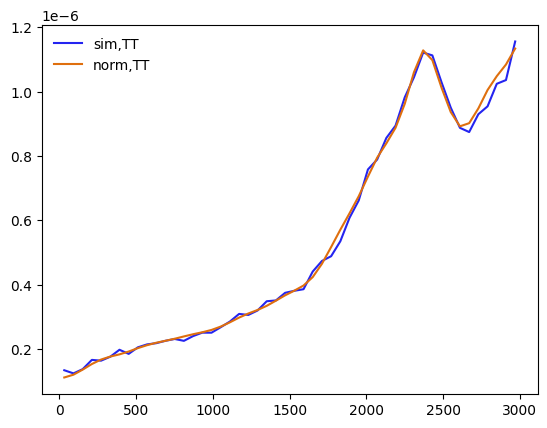

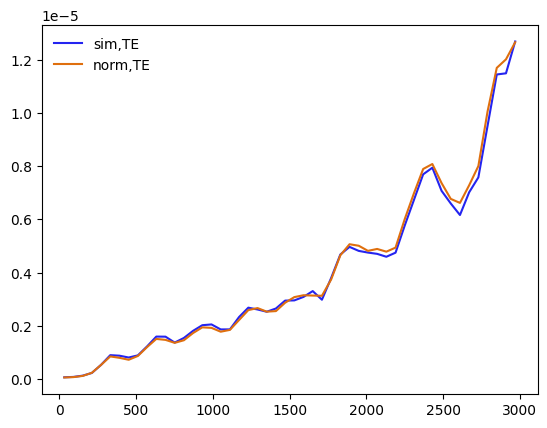

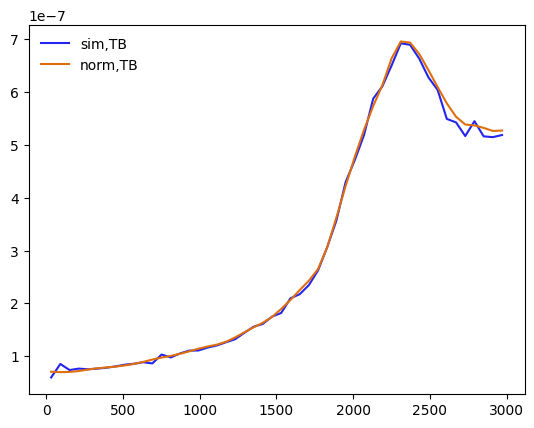

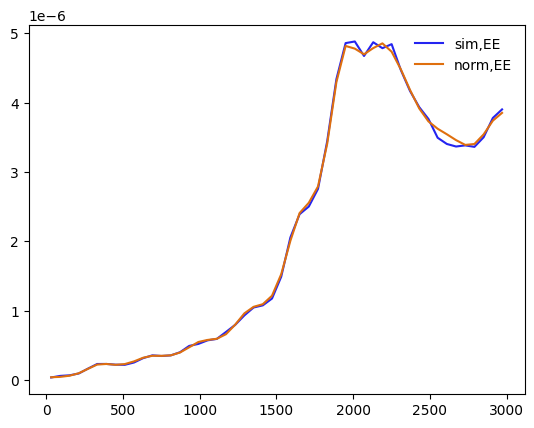

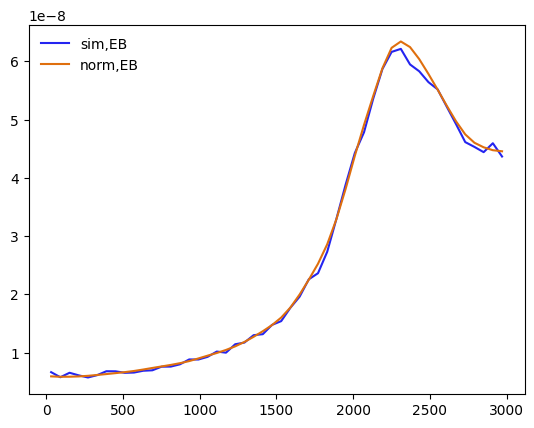

<Figure size 640x480 with 0 Axes>

In [14]:
for q in qlist:
    mcks = np.mean(cks[q],axis=0)
    plot(bc,mcks,label='sim,'+q)
    plot(bc,Alg[q],label='norm,'+q)
    legend()
    show()
    clf()